### Import Libraries

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import numpy as np

### Load and Inspect Data

In [2]:
df = pd.read_csv('U.S._Chronic_Disease_Indicators.csv')
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311745 entries, 0 to 311744
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   YearStart                  311745 non-null  int64  
 1   YearEnd                    311745 non-null  int64  
 2   LocationAbbr               311745 non-null  object 
 3   LocationDesc               311745 non-null  object 
 4   DataSource                 311745 non-null  object 
 5   Topic                      311745 non-null  object 
 6   Question                   311745 non-null  object 
 7   Response                   0 non-null       float64
 8   DataValueUnit              311745 non-null  object 
 9   DataValueType              311745 non-null  object 
 10  DataValue                  210684 non-null  float64
 11  DataValueAlt               210684 non-null  float64
 12  DataValueFootnoteSymbol    102758 non-null  object 
 13  DataValueFootnote          10

### Data Cleaning

In [3]:
cols = ['YearStart', 'LocationDesc', 'Topic', 'Question', 'DataValue',
        'LowConfidenceLimit', 'HighConfidenceLimit', 'StratificationCategory1',
        'Stratification1']
df_disease = df[cols]
df_disease = df_disease[df_disease['DataValue'].notnull()]  # Remove rows with missing target variable

### Focus on Specific Topics

In [4]:
topics_of_interest = ['Cardiovascular Disease', 'Cancer']
df_focus = df_disease[df_disease['Topic'].isin(topics_of_interest)]

# Show top questions for each topic
for topic in topics_of_interest:
    print(f"\nTop questions under '{topic}':")
    print(df_focus[df_focus['Topic'] == topic]['Question'].value_counts())


Top questions under 'Cardiovascular Disease':
Diseases of the heart mortality among all people, underlying cause                                          4570
Coronary heart disease mortality among all people, underlying cause                                         4222
Cerebrovascular disease (stroke) mortality among all people, underlying cause                               3897
Hospitalization for heart failure as principal diagnosis, Medicare-beneficiaries aged 65 years and older    3195
Taking medicine for high cholesterol among adults                                                           1965
High cholesterol among adults who have been screened                                                        1963
High blood pressure among adults                                                                            1916
Taking medicine to control high blood pressure among adults with high blood pressure                        1665
Name: Question, dtype: int64

Top questions under

### Focus on Key Questions

In [5]:
questions_to_explore = [
    "Diseases of the heart mortality among all people, underlying cause",
    "Coronary heart disease mortality among all people, underlying cause",
    "Invasive cancer (all sites combined) mortality among all people, underlying cause",
    "Invasive cancer (all sites combined), incidence"
]

df_selected = df_focus[df_focus['Question'].isin(questions_to_explore)].copy()
df_selected = df_selected[df_selected['DataValue'].notnull()]

### Visualize Trends Over Time

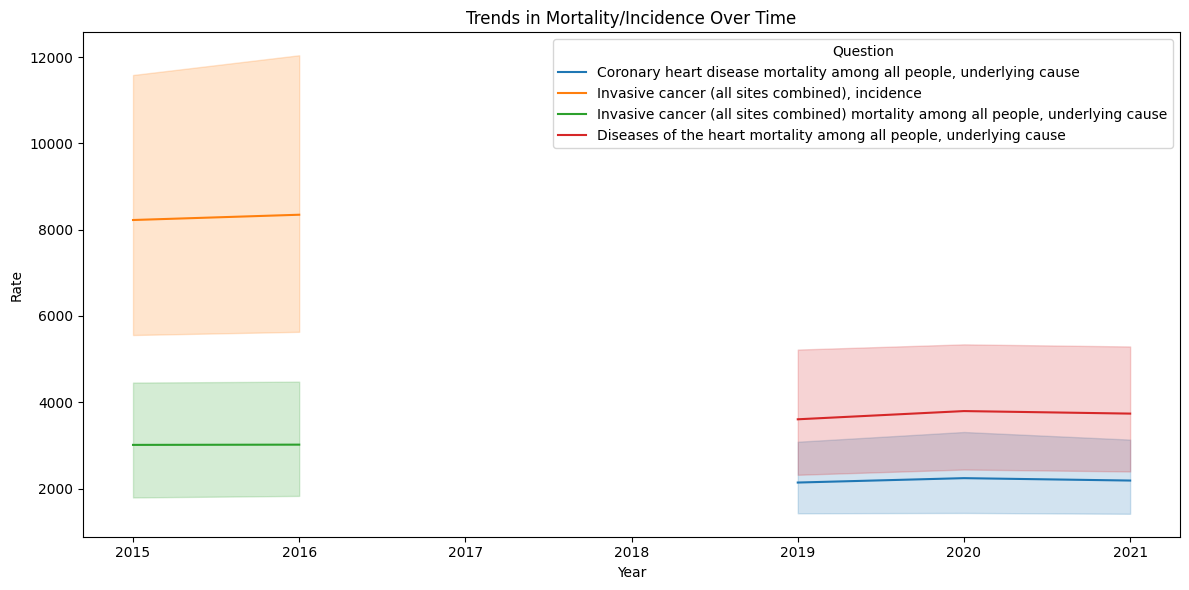

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_selected, x="YearStart", y="DataValue", hue="Question")
plt.title("Trends in Mortality/Incidence Over Time")
plt.xlabel("Year")
plt.ylabel("Rate")
plt.tight_layout()
plt.show()

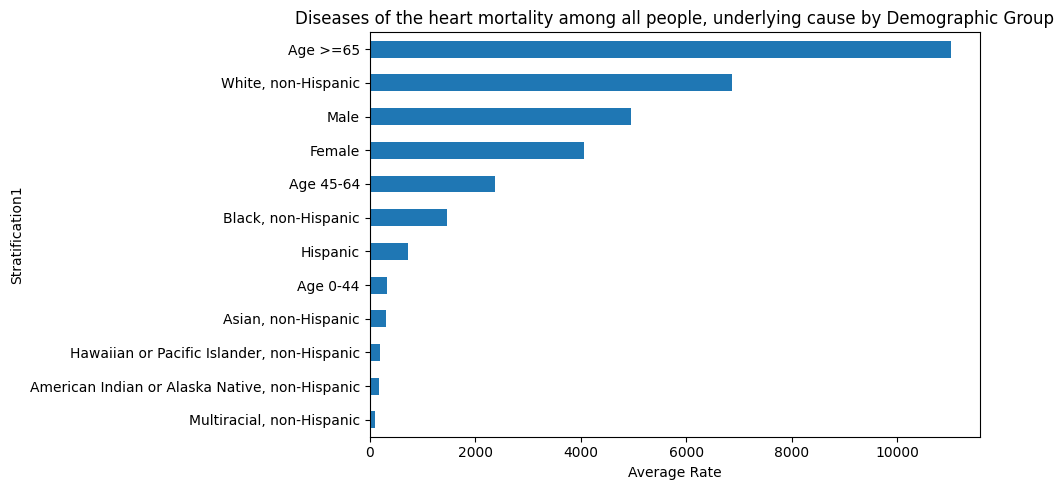

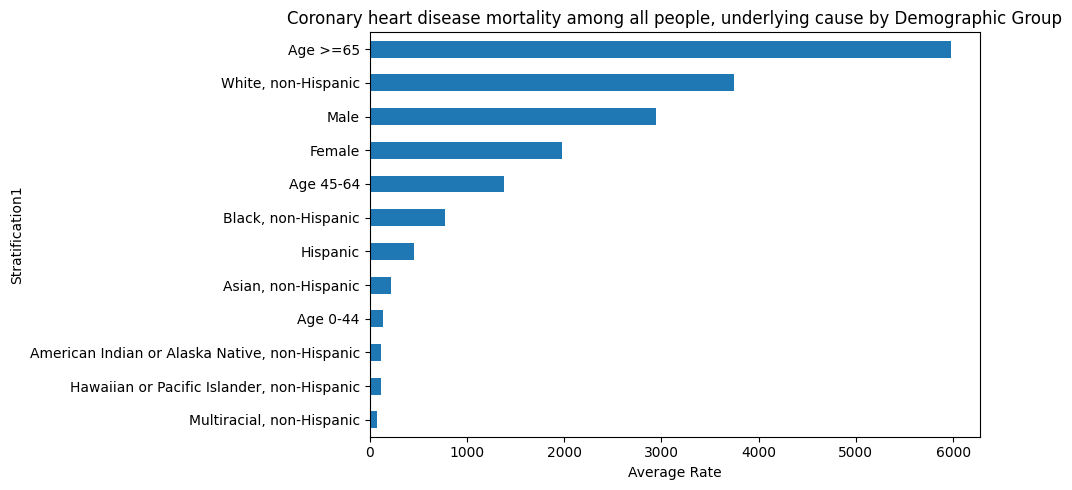

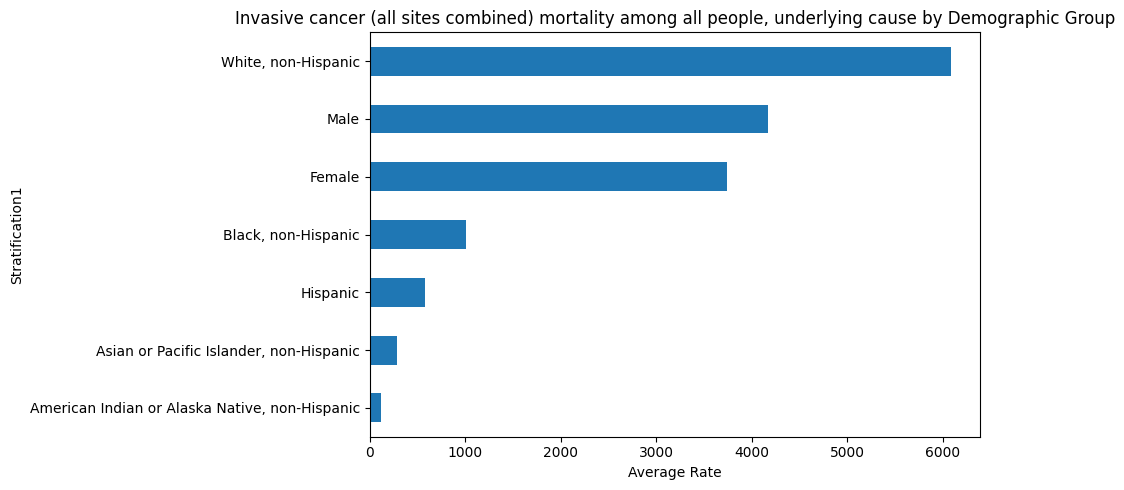

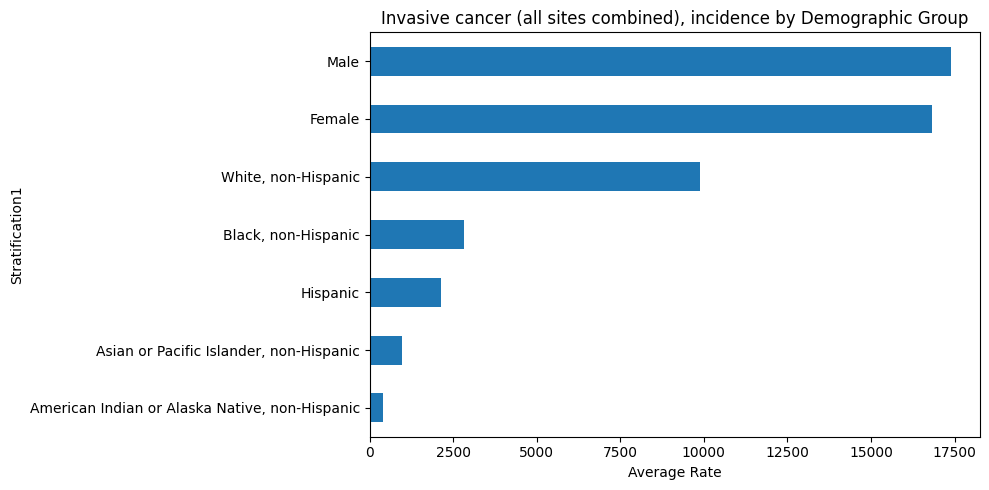

In [7]:
# Demographic stratification
for q in questions_to_explore:
    df_q = df_selected[(df_selected['Question'] == q) & (df_selected['Stratification1'] != 'Overall')]
    strat = df_q.groupby('Stratification1')['DataValue'].mean().sort_values()

    plt.figure(figsize=(10, 5))
    strat.plot(kind='barh')
    plt.title(f"{q} by Demographic Group")
    plt.xlabel("Average Rate")
    plt.tight_layout()
    plt.show()

### Filter & Feature Engineering

In [8]:
df_selected = df_selected[df_selected['DataValue'] < 1000]  # Remove outliers
df_model = df_selected[['YearStart', 'LocationDesc', 'Stratification1', 'Question', 'DataValue']].dropna()
df_model[['YearStart']] = StandardScaler().fit_transform(df_model[['YearStart']])
df_model = pd.get_dummies(df_model, columns=['LocationDesc', 'Stratification1', 'Question'], drop_first=True)

X = df_model.drop(columns=['DataValue'])
y = df_model['DataValue']

### Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Model (Initial)

In [10]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

print("\n===== Random Forest Results =====")
print(f"RMSE: {mean_squared_error(y_test, y_rf_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_rf_pred):.2f}")


===== Random Forest Results =====
RMSE: 25553.20
R² Score: 0.32


### XGBoost Model (Improved)

In [11]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)

print("\n===== XGBoost Results =====")
print(f"RMSE: {mean_squared_error(y_test, y_xgb_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_xgb_pred):.2f}")


===== XGBoost Results =====
RMSE: 18375.11
R² Score: 0.51


### Grid Search for XGBoost

In [12]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid = GridSearchCV(XGBRegressor(), param_grid, scoring='r2', cv=3)
grid.fit(X_train, y_train)

print("\n===== Grid Search Results =====")
print("Best Params:", grid.best_params_)
print("Best R²:", grid.best_score_)


===== Grid Search Results =====
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best R²: 0.5577333346238397


### Final XGBoost Model

In [13]:
final_model = XGBRegressor(**grid.best_params_)
final_model.fit(X_train, y_train)
y_final_pred = final_model.predict(X_test)

### Final Evaluation & Visualization

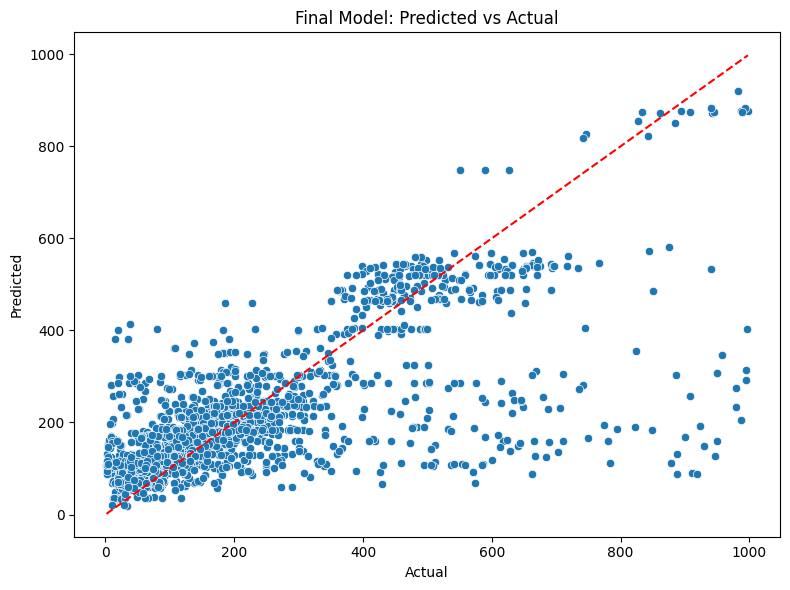

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_final_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Final Model: Predicted vs Actual")
plt.tight_layout()
plt.show()

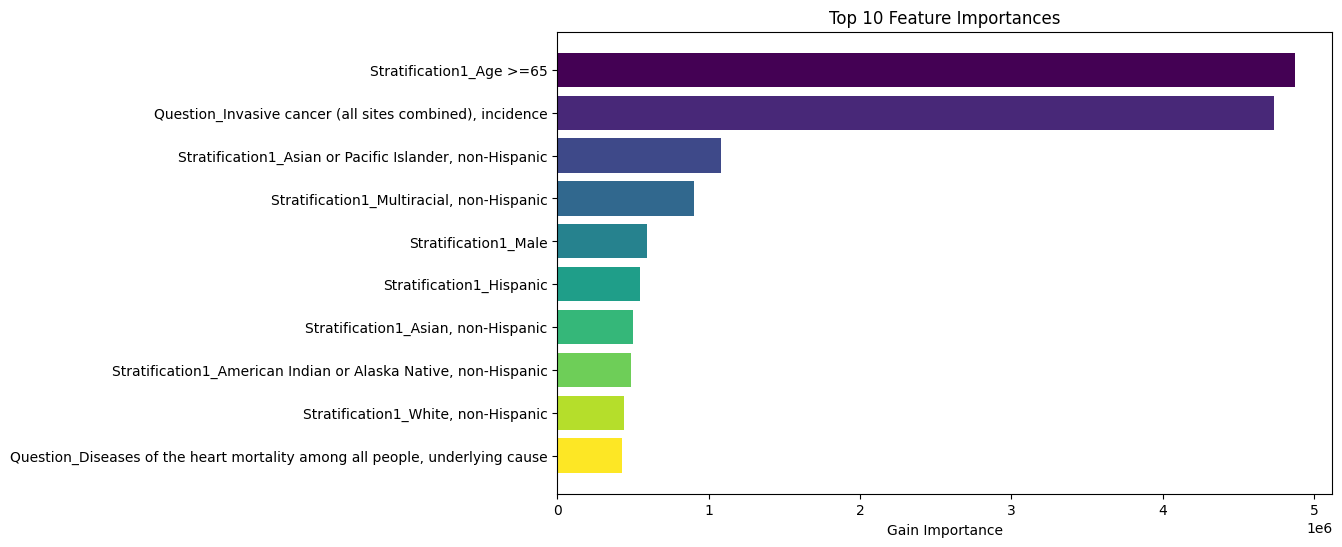

In [18]:
# Get feature importances and feature names
importance = final_model.get_booster().get_score(importance_type='gain')
features = list(importance.keys())
scores = list(importance.values())

# Sort by importance descending
sorted_idx = np.argsort(scores)[::-1]
sorted_features = [features[i] for i in sorted_idx][:10]
sorted_scores = [scores[i] for i in sorted_idx][:10]

# Define colors
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_scores)))

plt.figure(figsize=(10,6))
plt.barh(sorted_features[::-1], sorted_scores[::-1], color=colors[::-1])
plt.xlabel("Gain Importance")
plt.title("Top 10 Feature Importances")
#plt.tight_layout()
plt.show()